In [46]:
# Analytics libraries

import numpy as np # algebra linear
import pandas as pd # processamento de dados, arquivo CSV I/O
import seaborn as srn
import statistics  as sts
import matplotlib.pyplot as plt
import re

# Modelando
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from xgboost import XGBRegressor

In [47]:
# Inicialmente, a exploração e limpeza (se necessário) de dados.

In [48]:
dataset = pd.read_csv("car_price_dataset.csv")
dataset.head()

,Brand,Model,Year,Engine_Size,Fuel_Type,Transmission,Mileage,Doors,Owner_Count,Price
0,Kia,Rio,2020,4.2,Diesel,Manual,289944,3,5,8501
1,Chevrolet,Malibu,2012,2.0,Hybrid,Automatic,5356,2,3,12092
2,Mercedes,GLA,2020,4.2,Diesel,Automatic,231440,4,2,11171
3,Audi,Q5,2023,2.0,Electric,Manual,160971,2,1,11780
4,Volkswagen,Golf,2003,2.6,Hybrid,Semi-Automatic,286618,3,3,2867


In [49]:
dataset.shape

(10000, 10)

In [50]:
dataset.isnull().sum()

Brand           0
Model           0
Year            0
Engine_Size     0
Fuel_Type       0
Transmission    0
Mileage         0
Doors           0
Owner_Count     0
Price           0
dtype: int64

In [51]:
dataset.describe() 

,Year,Engine_Size,Mileage,Doors,Owner_Count,Price
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000
mean,2011.543700,3.000560,149239.111800,3.497100,2.991100,8852.96440
std,6.897699,1.149324,86322.348957,1.110097,1.422682,3112.59681
min,2000.000000,1.000000,25.000000,2.000000,1.000000,2000.00000
25%,2006.000000,2.000000,74649.250000,3.000000,2.000000,6646.00000
50%,2012.000000,3.000000,149587.000000,3.000000,3.000000,8858.50000
75%,2017.000000,4.000000,223577.500000,4.000000,4.000000,11086.50000
max,2023.000000,5.000000,299947.000000,5.000000,5.000000,18301.00000


In [52]:
# Aparentemente, nenhum outlier ou dado faltante
# Agora, para análise gráfica dos dados
# O que exatamente você acha que poderia influenciar o preço de um carro?
# Bom, na verdade, todas as informações presentes parecem influenciar o preço de alguma forma

In [53]:
dataset["Price"].describe()

count    10000.00000
mean      8852.96440
std       3112.59681
min       2000.00000
25%       6646.00000
50%       8858.50000
75%      11086.50000
max      18301.00000
Name: Price, dtype: float64

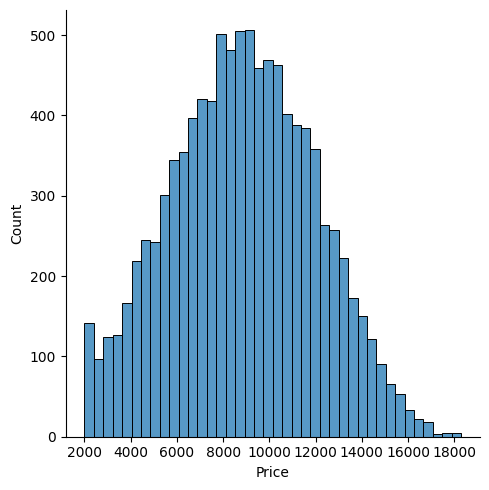

In [54]:
srn.displot(dataset['Price']);

In [55]:
print("Assimetria: %f" % dataset['Price'].skew())
print("Curtose: %f" % dataset['Price'].kurt())

Assimetria: 0.026136
Curtose: -0.481945


In [56]:
# Perfeito! Realmente não temos que nos preocupar com erros.
# Agora, vamos tentar encontrar as maiores relações com o preço

<Axes: xlabel='Year', ylabel='Price'>

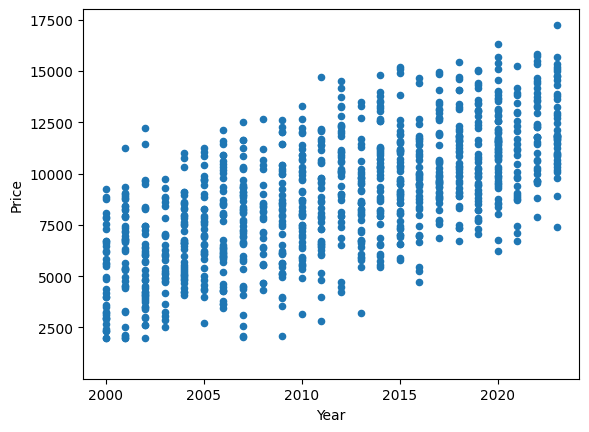

In [57]:
data = pd.concat([dataset.loc[:1000,['Price']], dataset['Year']], axis=1)
data.plot.scatter(x='Year', y='Price', ylim=(1))

<Axes: xlabel='Mileage', ylabel='Price'>

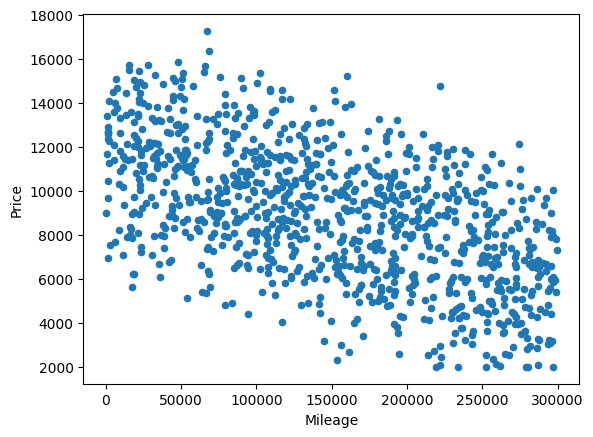

In [58]:
data = pd.concat([dataset.loc[:1000,['Price']], dataset['Mileage']], axis=1)
data.plot.scatter(x='Mileage', y='Price')

In [59]:
# Como esperado, carros mais antigos e mais rodados tendem a ser mais baratos...
# Isso provavelmente seria a mesma coisa para todos os dados, considerando as tendências
# Agora para a parte de treinamento de modelo
# Precisamos agora organizar os dados

In [60]:
X = dataset.drop(columns=['Price'], axis=1)
y = dataset['Price']

In [61]:
# Agora para o pré processador de colunas 
# Um pré processador de colunas é um componente usado para transformar os dados antes de alimentar um modelo de machine learning. Ele aplica diferentes tipos de pré processamento a diferentes colunas do dataset, garantindo que todas as variáveis fiquem no formato ideal para o modelo

In [62]:
var_num = X.select_dtypes(exclude="object").columns
var_cat = X.select_dtypes(include="object").columns

# Agora vamos transformar as variáveis categóricas em numéricas usando técnicas de encoding (como one-hot encoding)

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

# O Standard Scaler normaliza as variáveis numéricas para que tenham média 0 e desvio padrão 1
# O one hot encoder transformar as variáveis categóricas em variáveis binárias. 

preprocessor = ColumnTransformer([
    ('StandardScaler', StandardScaler(), var_num),
    ('OneHotEncoder', OneHotEncoder(handle_unknown='ignore'), var_cat)
])

# O handle unknown é para lidar com variáveis desconhecidas

In [63]:
X = preprocessor.fit_transform(X)
# aprende as estatísticas necessárias para a transformação dos dados
# aplica as transformações no conjunto de dados com base no que foi aprendido com o fit

In [64]:
X.shape

(10000, 52)

In [65]:
# Separar o dataset em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((8000, 52), (2000, 52), (8000,), (2000,))

Criando uma função de avaliação para dar todas as métricas depois de treinar o modelo

In [66]:
def evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train) 
    # Aqui, o modelo é treinado com dados de treinamento
    
    y_pred = model.predict(X_test) 
    # Após o treinamento, faz previsões usando dados de teste
    
    mse = mean_squared_error(y_test, y_pred) 
    # O MSE mede a média dos quadrados das diferenças entre os valores reais (y_test) e as previsões (y_pred). Quanto menor o MSE, melhor o modelo.
    
    mae = mean_absolute_error(y_test, y_pred) 
    # O MAE calcula a média das diferenças absolutas entre os valores reais e as previsões. Menores valores de MAE indicam melhor desempenho.
    
    r2 = r2_score(y_test, y_pred)
    # O R² indica quanto da variabilidade dos dados de teste pode ser explicada pelo modelo. O valor de R² varia de 0 a 1. Um valor de 1 indica um modelo perfeito, enquanto 0 significa que o modelo não explica nada da variabilidade dos dados.
    
    return mse, mae, r2
    
# model: O modelo de machine learning que você deseja treinar e avaliar. Esse modelo deve ter o método fit() (para treinar) e o método predict() (para fazer previsões).
# X_train: Os dados de entrada para treinar o modelo (variáveis independentes) para o conjunto de treinamento.
# X_test: Os dados de entrada para testar o modelo (variáveis independentes) para o conjunto de teste.
# y_train: Os rótulos ou valores reais associados aos dados de treino (variáveis dependentes).
# y_test: Os rótulos ou valores reais associados aos dados de teste.

In [67]:
models = {
    'KNeighborsRegressor' : KNeighborsRegressor(),
    'DecisionTreeRegressor' : DecisionTreeRegressor(),
    'AdaBoostRegressor' : AdaBoostRegressor(),
    'LinearRegression' : LinearRegression(),
    'Ridge' : Ridge(),
    'Lasso' : Lasso(),
    'XGBRegressor' : XGBRegressor()
}

model_list = [] 
r2_list = []
mse_list = []
for i in range(len(list(models))):
    model = list(models.values())[i]
    model.fit(X_train, y_train)
    
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    model_train_mse, model_train_mae, model_train_r2 = evaluate_model(model, X_train, X_train, y_train, y_train)
    model_test_mse, model_test_mae, model_test_r2 = evaluate_model(model, X_train, X_test, y_train, y_test)
    
    print(f'{list(models.keys())[i]}')
    model_list.append(list(models.keys())[i])
    
    print('Model performance for training set')
    print('- Root Mean Squared Error: {:.4f}'.format(model_train_mse))
    print('- Mean Absolute Error: {:.4f}'.format(model_train_mae))
    print('- R-squared: {:.4f}'.format(model_train_r2))
    
    print('=================================================')
    print('Model performance for test set')
    print('- Root Mean Squared Error: {:.4f}'.format(model_test_mse))
    print('- Mean Absolute Error: {:.4f}'.format(model_test_mae))
    print('- R-squared: {:.4f}'.format(model_test_r2))
    r2_list.append(model_test_r2)
    mse_list.append(model_test_mse)
    print('35'* 35)
    print('\n')
    
# O loop percorre todos os modelos definidos no dicionário.
# Para cada modelo, ele é treinado com os dados de treinamento (X_train, y_train).
# As previsões são feitas para o conjunto de treinamento e teste.
# O desempenho de cada modelo é avaliado com as métricas MSE, MAE e R² para os conjuntos de treinamento e teste.
# Os resultados são impressos e as métricas de desempenho para o conjunto de teste são salvas em listas.  

KNeighborsRegressor
Model performance for training set
- Root Mean Squared Error: 817747.4014
- Mean Absolute Error: 728.3626
- R-squared: 0.9166
Model performance for test set
- Root Mean Squared Error: 1127307.0581
- Mean Absolute Error: 848.8747
- R-squared: 0.8773
3535353535353535353535353535353535353535353535353535353535353535353535


DecisionTreeRegressor
Model performance for training set
- Root Mean Squared Error: 0.0000
- Mean Absolute Error: 0.0000
- R-squared: 1.0000
Model performance for test set
- Root Mean Squared Error: 379729.1385
- Mean Absolute Error: 478.8595
- R-squared: 0.9587
3535353535353535353535353535353535353535353535353535353535353535353535


AdaBoostRegressor
Model performance for training set
- Root Mean Squared Error: 825791.8949
- Mean Absolute Error: 726.3415
- R-squared: 0.9158
Model performance for test set
- Root Mean Squared Error: 790657.1532
- Mean Absolute Error: 712.8059
- R-squared: 0.9139
35353535353535353535353535353535353535353535353535353535

In [68]:
pd.DataFrame(list(zip(model_list, r2_list, mse_list)), columns=['Model', 'R^2','MSE']).sort_values(by = 'R^2', ascending = False)

,Model,R^2,MSE
3,LinearRegression,0.999541,4.213925e+03
5,Lasso,0.999541,4.217854e+03
4,Ridge,0.999541,4.218324e+03
6,XGBRegressor,0.993755,5.737476e+04
1,DecisionTreeRegressor,0.958670,3.797291e+05
2,AdaBoostRegressor,0.913945,7.906572e+05
0,KNeighborsRegressor,0.877304,1.127307e+06


In [69]:
# Cria uma instância do modelo de regressão linear
# O método predict usa o modelo treinado para fazer previsões. Os dados X_test são dados que o modelo nunca viu antes
# A função R2_score calcula o valor de R²(coeficiente de determinação) que mede a qualidade do ajute do modelo aos dados reais

lin_model = LinearRegression().fit(X_train, y_train)
y_pred = lin_model.predict(X_test)
score = r2_score(y_test, y_pred) * 100
print("Accuracy of the model: ", score) 

Accuracy of the model:  99.95413570907378


Plot y_pred e y_test

<Axes: xlabel='Price'>

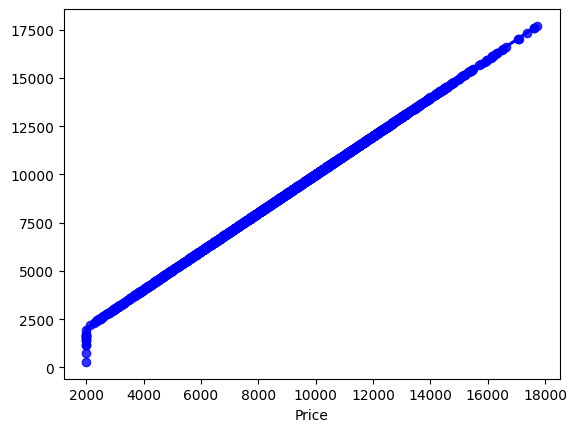

In [70]:
srn.regplot(x = y_test, y= y_pred, ci=None, color='blue')

In [71]:
pred_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred, 'Difference': y_test - y_pred})
pred_df

,Actual,Predicted,Difference
6252,2000,1691.445781,308.554219
4684,11164,11149.127525,14.872475
1731,14630,14601.971472,28.028528
4742,7334,7348.983842,-14.983842
4521,10127,10146.193275,-19.193275
...,...,...,...
6412,4681,4710.409005,-29.409005
8285,12839,12812.074663,26.925337
7853,8124,8131.167197,-7.167197
1095,6709,6724.651517,-15.651517
